In [1]:
%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [3]:
import load as ld
import preprocessing as pp
import training as tr

import warnings
warnings.filterwarnings('ignore')

/anaconda3/envs/kaggle/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [4]:
debug_size = 0
silent = True
verbose = 200
early_stopping_rounds = 200

In [5]:
def get_datasets(debug_size, silent, treat_duplicated = True):
    train, test = ld.get_processed_files(debug_size, silent)
    features = [f for f in train.columns if f not in ['target', 'card_id', 'index', 'first_active_month']]
    
    train_y = train['target']
    train_X = train.loc[:, features]

    ids = test['card_id']
    test_X = test.loc[:, features]
    
    return train_X, train_y, test_X, ids

In [6]:
%%time
train_X, train_y, test_X, ids = get_datasets(debug_size = debug_size, silent = silent)
features = train_X.columns.tolist()

Process train and test - Start!
Process train and test - Done in 2s

CPU times: user 1.98 s, sys: 100 ms, total: 2.08 s
Wall time: 2.08 s


In [7]:
features = train_X.columns.tolist()

In [8]:
# Booster params
lgb_params = {}
lgb_params['n_estimators'] = 10000
lgb_params['learning_rate'] = 0.005
lgb_params['metric'] = 'rmse'
lgb_params['objective'] = 'regression'

# Fitting params
lgb_fit_params = {}
lgb_fit_params['verbose_eval'] = verbose
lgb_fit_params['early_stopping_rounds'] = early_stopping_rounds
lgb_fit_params['valid_sets'] = {}
lgb_fit_params['valid_names'] = ["validation"]

In [9]:
lgbm = tr.LightGBMRegressorWrapper(params = lgb_params, name = "lgbm")

In [10]:
oof_lgbm = tr.OOFRegressor(regressor = lgbm, nfolds = 5, stratified = False)

In [11]:
oof_lgbm.fit(train_X.loc[:, features], train_y, **lgb_fit_params)

Training until validation scores don't improve for 200 rounds.
[200]	validation's rmse: 3.80494
[400]	validation's rmse: 3.80478
Early stopping, best iteration is:
[288]	validation's rmse: 3.80464
Fold  1 RMSE : 3.804640
Training until validation scores don't improve for 200 rounds.
[200]	validation's rmse: 3.83575
[400]	validation's rmse: 3.83503
[600]	validation's rmse: 3.83515
Early stopping, best iteration is:
[455]	validation's rmse: 3.83502
Fold  2 RMSE : 3.835020
Training until validation scores don't improve for 200 rounds.
[200]	validation's rmse: 3.91665
[400]	validation's rmse: 3.91553
[600]	validation's rmse: 3.9157
Early stopping, best iteration is:
[428]	validation's rmse: 3.9155
Fold  3 RMSE : 3.915497
Training until validation scores don't improve for 200 rounds.
[200]	validation's rmse: 3.89375
[400]	validation's rmse: 3.89288
[600]	validation's rmse: 3.89302
Early stopping, best iteration is:
[415]	validation's rmse: 3.89288
Fold  4 RMSE : 3.892878
Training until vali

OOFRegressor(nfolds=5,
       regressor=LightGBMRegressorWrapper(name='lgbm',
             params={'n_estimators': 10000, 'learning_rate': 0.005, 'metric': 'rmse', 'objective': 'regression'}),
       stratified=False, weights='same')

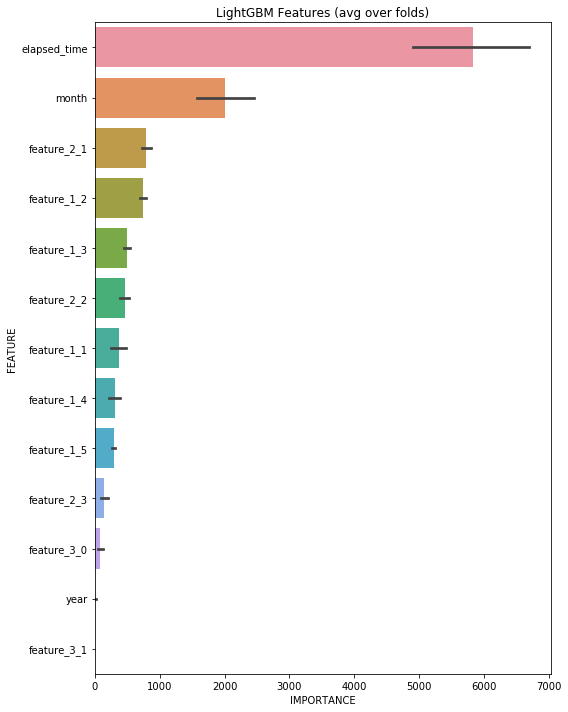

In [12]:
tr.display_importances(oof_lgbm.importances_)

In [ ]:
# BOOSTER PARAMS
xgb_params = dict()
xgb_params["booster"] = "gbtree"
xgb_params["objective"] = "reg:linear"
#xgb_params["colsample_bytree"] = 0.9497036
#xgb_params["subsample"] = 0.8715623
#xgb_params["max_depth"] = 8
#xgb_params['reg_alpha'] = 0.041545473
#xgb_params['reg_lambda'] = 0.0735294
xgb_params["learning_rate"] = 0.005
#xgb_params["min_child_weight"] = 39.3259775
xgb_params['eval_metric'] = 'rmse'
xgb_params['silent'] = 1

# FITTING PARAMS
xgb_fit_params = {}
xgb_fit_params['verbose_eval'] = verbose
xgb_fit_params['early_stopping_rounds'] = early_stopping_rounds
xgb_fit_params['evals'] = {}
xgb_fit_params['num_boost_round'] = 10000

In [ ]:
xgb = tr.XgbRegressorWrapper(params = xgb_params, name = "xgboost")

In [ ]:
oof_xgb = tr.OOFRegressor(regressor = xgb, nfolds = 5, stratified = False)

In [ ]:
oof_xgb.fit(train_X.loc[:, features], train_y, **xgb_fit_params)

In [ ]:
tr.display_importances(oof_xgb.importances_)

In [13]:
def baseline_nn(n_features = 75):
    model = Sequential()
    model.add(Dense(64, input_dim=n_features, init='normal', activation='sigmoid'))
    model.add(Dense(1, init='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
    return model

In [14]:
sk_params = dict()
sk_params["n_features"] = train_X.shape[1]
sk_params["batch_size"] = 32
sk_params["verbose"] = 1

In [15]:
nn_model = baseline_nn(train_X.shape[1])
nn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                896       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________


In [16]:
early_stop_loss = EarlyStopping(monitor='val_loss', patience=15, verbose=0)
early_stop_acc = EarlyStopping(monitor='val_acc', patience=15, verbose=0)
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.hdf5', verbose=1, save_best_only=True)

In [18]:
hist = nn_model.fit(train_X.loc[:, features].values, train_y.values, validation_split=0.1, 
                            epochs=10, batch_size=256, callbacks=[checkpointer], verbose=1)

Train on 181725 samples, validate on 20192 samples
Epoch 1/10
181725/181725 [==============================] - 1s 5us/step - loss: 14.7211 - mean_absolute_error: 1.5977 - val_loss: 15.2898 - val_mean_absolute_error: 1.6139

Epoch 00001: val_loss did not improve from 15.28564
Epoch 2/10
181725/181725 [==============================] - 1s 5us/step - loss: 14.7264 - mean_absolute_error: 1.5977 - val_loss: 15.2867 - val_mean_absolute_error: 1.6036

Epoch 00002: val_loss did not improve from 15.28564
Epoch 3/10
181725/181725 [==============================] - 1s 5us/step - loss: 14.7218 - mean_absolute_error: 1.5998 - val_loss: 15.2834 - val_mean_absolute_error: 1.6099

Epoch 00003: val_loss improved from 15.28564 to 15.28344, saving model to saved_models/weights.best.hdf5
Epoch 4/10
181725/181725 [==============================] - 1s 5us/step - loss: 14.7208 - mean_absolute_error: 1.6005 - val_loss: 15.2835 - val_mean_absolute_error: 1.6065

Epoch 00004: val_loss did not improve from 15.28

In [19]:
pred = nn_model.predict(test_X.loc[:, features].values)

In [44]:
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold

variance_threshold = (.98 * (1 - .98))

pipe_variance = Pipeline([('scaler', RobustScaler()),
                              ('reduce_dim', VarianceThreshold(variance_threshold))])
pipe_variance.fit(train_X, train_y)

Pipeline(steps=[('scaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('reduce_dim', VarianceThreshold(threshold=0.019600000000000017))])

In [45]:
train_X_pipe = pipe_variance.transform(train_X)

In [46]:
test_X_pipe = pipe_variance.transform(test_X)

In [41]:
hist = nn_model.fit(train_X_pipe, train_y.values, validation_split=0.1, 
                            epochs=10, batch_size=256, callbacks=[checkpointer], verbose=1)

Train on 181725 samples, validate on 20192 samples
Epoch 1/10
181725/181725 [==============================] - 1s 5us/step - loss: 14.7289 - mean_absolute_error: 1.5999 - val_loss: 15.2895 - val_mean_absolute_error: 1.6160

Epoch 00001: val_loss did not improve from 15.28344
Epoch 2/10
181725/181725 [==============================] - 1s 5us/step - loss: 14.7231 - mean_absolute_error: 1.5994 - val_loss: 15.2970 - val_mean_absolute_error: 1.6370

Epoch 00002: val_loss did not improve from 15.28344
Epoch 3/10
181725/181725 [==============================] - 1s 5us/step - loss: 14.7232 - mean_absolute_error: 1.6001 - val_loss: 15.2956 - val_mean_absolute_error: 1.5961

Epoch 00003: val_loss did not improve from 15.28344
Epoch 4/10
181725/181725 [==============================] - 1s 5us/step - loss: 14.7218 - mean_absolute_error: 1.6000 - val_loss: 15.2952 - val_mean_absolute_error: 1.5954

Epoch 00004: val_loss did not improve from 15.28344
Epoch 5/10
181725/181725 [=======================